# 🎯 Model Training with Optuna Hyperparameter Optimization and unbalanced data handling

This notebook implements model training with balanced classes using Optuna for hyperparameter optimization. The process includes:

- 📊 Data loading and preprocessing,
- 🔄 Cross-validation with stratified k-folds,
- ⚖️ Class balancing using RandomUnderSampler,
- 🎮 Hyperparameter optimization with Optuna,
- 📈 Model evaluation and visualization,
- 💾 Model persistence,

## Table of Contents
1. [Import Libraries and Load Data](#import-libraries),
2. [Support Functions](#support-functions),
3. [Hyperparameter Optimization](#optimization),
4. [Visualization of Results](#visualization),
5. [Final Model Training](#final-model),
6. [Model Evaluation](#evaluation)


In [11]:
%reload_ext autoreload
%autoreload 2

## 📚 Import Libraries and Load Data <a name="import-libraries"></a>

In [12]:
# Standard library imports
import pandas as pd
import numpy as np
import sys
from functools import partial
from statistics import median
from tqdm import tqdm

# Machine Learning imports
from lightgbm import LGBMClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Optimization library
import optuna

# Custom utilities
sys.path.append('../')

# Load training data
X = pd.read_parquet('../data/train_data.parquet')
metadata_columns = ['trans_date_trans_time', 'gender', 'street']
train_y = X['is_fraud']
train_X = X.drop(columns=['is_fraud'] + metadata_columns)

# Load holdout and OOT data
holdout = pd.read_parquet('../data/holdout_data.parquet')
holdout_y = holdout['is_fraud']
holdout_X = holdout.drop(columns=['is_fraud'] + metadata_columns)

oot = pd.read_parquet('../data/oot_data.parquet')
oot_y = oot['is_fraud']
oot_X = oot.drop(columns=['is_fraud'] + metadata_columns)

## 🛠️ Support Functions <a name="support-functions"></a>

In [13]:
def model_training_kfold(train_X, train_y, hyperparameters, nr_folds=3):
    """Train a model using k-fold cross validation with undersampling.
    
    Args:
        train_X (pd.DataFrame): Training features
        train_y (pd.Series): Training labels
        hyperparameters (dict): Model hyperparameters
        nr_folds (int): Number of folds for cross-validation
        
    Returns:
        tuple: (validation_scores, training_scores, trained_model)
    """
    # Initialize cross-validation and undersampling
    skf = StratifiedKFold(n_splits=nr_folds, shuffle=True, random_state=42)
    undersample_func=RandomUnderSampler(sampling_strategy=0.3, random_state=42)
    # initialize the model
    lgbm_model = LGBMClassifier( random_state=42, n_jobs=-1, metric="average_precision",verbosity=-1 ) #verbosity=-1 to suppress the warning to push the code. Normally it should be at least 0, better 1.

    train_scores: list[float] = []
    val_scores: list[float] = []

    for _, (train_index, test_index)  in tqdm(enumerate(skf.split(train_X, train_y)), desc="Generating K-Folds", total=3):
        # Split data
        train_df, y_train = train_X.iloc[train_index], train_y.iloc[train_index]
        test_df, y_test = train_X.iloc[test_index], train_y.iloc[test_index]

        # Undersample the training data
        train_df, y_train = undersample_func.fit_resample(train_df, y_train)

        # Fit the classifier on the training data
        lgbm_model.set_params(**hyperparameters)

        # Fit the classifier on the training data   
        lgbm_model.fit(
            train_df,
            y_train,
            eval_set=[(test_df, y_test)]
        )        

        # Make predictions
        y_pred = lgbm_model.predict(test_df)#[:,1]
        y_pred_train = lgbm_model.predict(train_X)#[:,1]

        # Calculate precision scores
        train_scores.append(precision_score(train_y, y_pred_train))
        val_scores.append(precision_score(y_test, y_pred))     

    return val_scores, train_scores, lgbm_model



def objective(trial: optuna.Trial, nr_folds: int = 3):
    """Optuna objective function for hyperparameter optimization.
    
    Args:
        trial (optuna.Trial): Optuna trial object
        nr_folds (int): Number of folds for cross-validation
        
    Returns:
        float: Median validation score across folds
    """
    # Define hyperparameters
    hyperparameters = {
        "objective": "binary",
        "n_estimators": trial.suggest_int("n_estimators", 10, 500),
        "early_stopping_round": 10,
        "first_metric_only": True,
        "num_leaves": trial.suggest_int("num_leaves", 2, (2**6) - 1, log=True),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 2, 256),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.5,log=True),
        'reg_alpha' : trial.suggest_int('reg_alpha',1,6),
        #'reg_lambda' : trial.suggest_int('reg_lambda',1,4),
        'n_jobs' : -1
    }

    val_scores, _, _ = model_training_kfold(train_X, train_y, hyperparameters, nr_folds=nr_folds)

    return median(val_scores)
    


## 🎮 Hyperparameter Optimization <a name="optimization"></a>

In [14]:
print("🔍 Starting Optuna Hyperparameter Optimization")
print("Optuna Tuning")
#hyperparameters, best_score, 
study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())
objective = partial(objective, nr_folds=5)
study.optimize(objective, n_trials=30)

[I 2025-07-01 10:34:02,296] A new study created in memory with name: no-name-cb7ef72c-0e2c-40a9-9f72-5915aaba61ce


🔍 Starting Optuna Hyperparameter Optimization
Optuna Tuning


Generating K-Folds: 5it [00:07,  1.41s/it]                       
[I 2025-07-01 10:34:09,442] Trial 0 finished with value: 0.25153778558875217 and parameters: {'n_estimators': 165, 'num_leaves': 22, 'min_data_in_leaf': 52, 'learning_rate': 0.05163640252939512, 'reg_alpha': 3}. Best is trial 0 with value: 0.25153778558875217.
Generating K-Folds: 5it [00:02,  1.90it/s]                       
[I 2025-07-01 10:34:12,078] Trial 1 finished with value: 0.28217403548296255 and parameters: {'n_estimators': 34, 'num_leaves': 6, 'min_data_in_leaf': 192, 'learning_rate': 0.09426704679650594, 'reg_alpha': 2}. Best is trial 1 with value: 0.28217403548296255.
Generating K-Folds:   0%|          | 0/3 [00:00<?, ?it/s]/Users/valeria.verzi/IKN/IKN-CAIO/fraud-modeling/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

In [30]:
print('📊 Number of finished trials:', len(study.trials))

📊 Number of finished trials: 30


In [16]:
print('🏆 Best parameters found:')
study.best_trial.params

🏆 Best parameters found:


{'n_estimators': 10,
 'num_leaves': 51,
 'min_data_in_leaf': 191,
 'learning_rate': 0.05766481015960131,
 'reg_alpha': 1}

In [17]:
print('📈 Best trial report:')
study.best_trial.report

📈 Best trial report:


<bound method FrozenTrial.report of FrozenTrial(number=28, state=1, values=[0.40704584040747027], datetime_start=datetime.datetime(2025, 7, 1, 10, 37, 8, 923338), datetime_complete=datetime.datetime(2025, 7, 1, 10, 37, 11, 120322), params={'n_estimators': 10, 'num_leaves': 51, 'min_data_in_leaf': 191, 'learning_rate': 0.05766481015960131, 'reg_alpha': 1}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=500, log=False, low=10, step=1), 'num_leaves': IntDistribution(high=63, log=True, low=2, step=1), 'min_data_in_leaf': IntDistribution(high=256, log=False, low=2, step=1), 'learning_rate': FloatDistribution(high=0.5, log=True, low=0.001, step=None), 'reg_alpha': IntDistribution(high=6, log=False, low=1, step=1)}, trial_id=28, value=None)>

## 📊 Visualization of Results <a name="visualization"></a>

In [18]:
print('📈 Optimization History')
optuna.visualization.plot_optimization_history(study)

📈 Optimization History


In [19]:
print('🎯 Parameter Importances')
optuna.visualization.plot_param_importances(study)

🎯 Parameter Importances


In [20]:
print('🔄 Parallel Coordinate Plot')
optuna.visualization.plot_parallel_coordinate(study)

🔄 Parallel Coordinate Plot


In [21]:
print('📊 Empirical Distribution Function')
optuna.visualization.plot_edf(study)

📊 Empirical Distribution Function


## 🎯 Final Model Training <a name="final-model"></a>

In [22]:
best_params = study.best_trial.params

### 📊 Model Stability Across Folds

In [23]:
nr_folds = 10
val_scores, train_scores, lgbm_model = model_training_kfold(train_X, train_y, best_params, nr_folds=nr_folds)

Generating K-Folds: 10it [00:04,  2.45it/s]                      


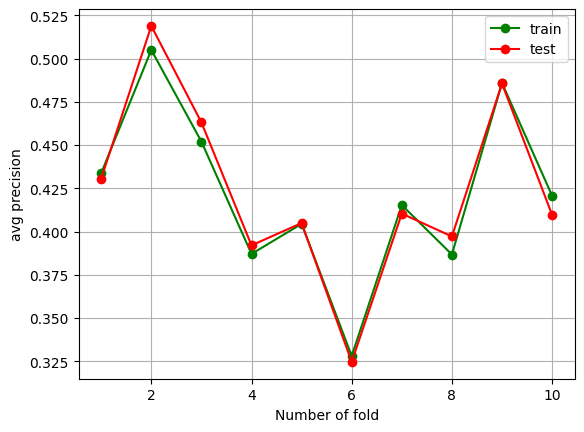

In [24]:
from matplotlib import pyplot as plt
folds = range(1, nr_folds+1)
plt.plot(folds, train_scores, 'o-', color='green', label='train')
plt.plot(folds, val_scores, 'o-', color='red', label='test')
plt.legend()
plt.grid()
plt.xlabel('Number of fold')
plt.ylabel('avg precision')
plt.show()

## Build final model

In [25]:

optuna_model = LGBMClassifier(**best_params)
undersample_func=RandomUnderSampler(sampling_strategy=0.2, random_state=42)
train_df, y_train = undersample_func.fit_resample(train_X, train_y)
optuna_model.fit(train_df, y_train)

# Evaluate the model
y_pred = optuna_model.predict(holdout_X)
y_pred_proba = optuna_model.predict_proba(holdout_X)[:, 1]

## 💾 Save Final Model

In [26]:
import pickle
print('💾 Saving model to disk...')
with open('../models/optuna_model.pkl', 'wb') as f:
    pickle.dump(optuna_model, f)
print('✅ Model saved successfully!')

💾 Saving model to disk...
✅ Model saved successfully!


## 📊 Model Evaluation <a name="evaluation"></a>

Optuna Model Classification Report on holdout:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    263819
           1       0.73      0.60      0.66      1528

    accuracy                           1.00    265347
   macro avg       0.86      0.80      0.83    265347
weighted avg       1.00      1.00      1.00    265347



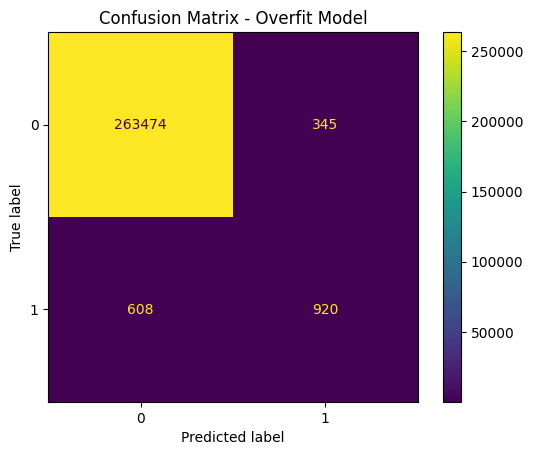

Overfit model training complete.


In [27]:

print('Optuna Model Classification Report on holdout:')
print(classification_report(holdout_y, y_pred))

cm_overfit = confusion_matrix(holdout_y, y_pred)
disp_overfit = ConfusionMatrixDisplay(cm_overfit)
disp_overfit.plot()
plt.title('Confusion Matrix - Overfit Model')
plt.show()
print("Overfit model training complete.")

In [28]:
import sys
sys.path.append('../../')
from utils.eval_plots import EvalPlots
from utils.model_performance_report import ModelPerformanceReport

report_class = Report()
eval_plots_class = EvalPlots()

In [31]:
# Load evaluation data
holdout = pd.read_parquet('../data/holdout_data.parquet')
oot = pd.read_parquet('../data/oot_data.parquet')

In [32]:
# Prepare evaluation features
holdout_X = holdout.drop(columns=['is_fraud']+metadata_columns)[train_X.columns]
holdout_y = holdout['is_fraud']

oot_X = oot.drop(columns=['is_fraud']+metadata_columns)[train_X.columns]
oot_y = oot['is_fraud']

In [33]:
# Initialize evaluation classes
report_class = ModelPerformanceReport(train_X,train_y,holdout_X,holdout_y,oot_X,oot_y)
eval_plots = EvalPlots()

In [34]:
report_class.produce_report(optuna_model)

,train,holdout,oot
accuracy,0.996534,0.996408,0.997283
precision,0.742715,0.727273,0.659389
recall,0.608902,0.602094,0.600398
f1,0.669184,0.658790,0.628512


In [35]:
print('📈 Generating Prediction Distributions')
y_train_pred, y_train_true, y_holdout_pred, y_holdout_true, y_oot_true, y_oot_pred = report_class.predictions(optuna_model)

📈 Generating Prediction Distributions


In [36]:
report_class.plot_eval_pred_dist(y_train_true, y_train_pred, y_holdout_true, y_holdout_pred, y_oot_true, y_oot_pred)

In [37]:
print('🎯 Generating PR-AUC Report')
report_class.produce_pr_auc_report(optuna_model)

🎯 Generating PR-AUC Report
